In [2]:
!pip install -r requirements.txt

In [3]:
import kagglehub
# path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
path = kagglehub.dataset_download("jangedoo/utkface-new")

/home/e20240011884/Documents/M2/Image, sécurité et deep learning/face_filters/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import cv2
import os

In [5]:
# Load face detection classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [6]:
image_size = 128
images = []
ages = []

In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not load image {img_path}. Skipping.")
        return []

    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(
        grey_img, scaleFactor=1.1, minNeighbors=5, minSize=(120, 120)
    )

    crops = []
    for (x, y, w, h) in faces:
        x_max = min(img.shape[1], x + w)
        y_max = min(img.shape[0], y + h)
        x = max(0, x)
        y = max(0, y)

        if w <= 0 or h <= 0:
            continue

        im_cropped = img[y:y_max, x:x_max]
        if im_cropped.size == 0:
            continue

        im_cropped = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2RGB)
        im_cropped = cv2.resize(im_cropped, (image_size, image_size))
        im_cropped = im_cropped.astype("float32") / 255.0
        crops.append(im_cropped)

    return crops

In [8]:
i = 0
numImg = 25000
for root, dirs, files in os.walk(path):
    for file in files:
        if i >= numImg:
            break
        if file.endswith(".jpg"):
            img_path = os.path.join(root, file)
            processed_crops = preprocess_image(img_path)
            age = int(file.split("_")[0])
            if len(processed_crops) == 0:
                continue
            for crop in processed_crops:
                images.append(crop)
                normalized_age = age / 116
                ages.append(normalized_age)
                i += 1
                if i >= numImg:
                    break

In [9]:
!pip show tensorflow

Name: tensorflow
Version: 2.20.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/e20240011884/Documents/M2/Image, sécurité et deep learning/face_filters/.venv/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google_pasta, grpcio, h5py, keras, libclang, ml_dtypes, numpy, opt_einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing_extensions, wrapt
Required-by: 


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input

2025-11-28 13:16:41.049179: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 13:16:41.085272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 13:16:49.967489: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

x_train, x_test, x_train_ages, x_test_ages = train_test_split(
    images, ages, test_size=0.2, random_state=42
)

x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)

x_train_ages = np.array(x_train_ages, dtype=np.float32).reshape(-1,1)
x_test_ages = np.array(x_test_ages, dtype=np.float32).reshape(-1,1)

# Crear datasets de tf.data
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train_ages))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test_ages))
val_dataset = val_dataset.batch(batch_size)

print(x_train.shape, x_train_ages.shape)
print(x_test.shape, x_test_ages.shape)


I0000 00:00:1764332218.486610   29057 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7063 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


(20000, 128, 128, 3) (20000, 1)
(5000, 128, 128, 3) (5000, 1)


In [12]:

from keras.saving import register_keras_serializable

def residual_block(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding="same")(shortcut)
    x = layers.Conv2D(filters, 3, strides=strides, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

def build_encoder(latent_dim):
    encoder_inputs = Input(shape=(128,128,3))
    age_input = Input(shape=(1,))

    x = layers.Conv2D(16, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
    x = residual_block(x, 32, strides=2)
    x = residual_block(x, 64, strides=2)
    x = residual_block(x, 128, strides=2)

    x_flat = layers.Flatten()(x)
    x_flat = layers.Dense(256, activation="relu")(x_flat)

    # Concatenar edad
    age_encoded = layers.Dense(32, activation="relu")(age_input)
    x_flat = layers.Concatenate()([x_flat, age_encoded])

    z_mean = layers.Dense(latent_dim)(x_flat)
    z_log_var = layers.Dense(latent_dim)(x_flat)

    @register_keras_serializable()
    def sampling(args):
        mean, log_var = args
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

    z = layers.Lambda(sampling)([z_mean, z_log_var])

    return Model([encoder_inputs, age_input], [z_mean, z_log_var, z], name="encoder")



In [13]:
def build_decoder(latent_dim):
    z_inputs = Input(shape=(latent_dim,))
    age_input = Input(shape=(1,))

    # Procesar edad
    age_encoded = layers.Dense(32, activation="relu")(age_input)
    age_encoded = layers.Reshape((1,1,32))(age_encoded)
    age_encoded = layers.Lambda(lambda t: tf.tile(t, [1, 8, 8, 1]))(age_encoded)

    # Reconstrucción desde el latente
    x = layers.Dense(8*8*128, activation="relu")(z_inputs)
    x = layers.Reshape((8,8,128))(x)

    # Concatenar información de edad
    x = layers.Concatenate()([x, age_encoded])

    # Upsampling progresivo sin skips
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.UpSampling2D()(x)

    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
    x = layers.UpSampling2D()(x)

    outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

    # Predicción de edad
    flat = layers.Flatten()(x)
    age_pred = layers.Dense(1, activation="linear", name="age_pred")(flat)

    return Model([z_inputs, age_input], [outputs, age_pred], name="decoder")



In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from keras_facenet import FaceNet
identity_model = FaceNet().model
identity_model.trainable = False

kl_weight = 1.0
p_weight = 0.5
identity_weight = 0.2
age_weight = 0.2

# --- Preparar modelo VGG para perceptual loss ---
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(128,128,3))
vgg.trainable = False
layer_names = ['block3_conv3', 'block4_conv3']
vgg_outputs = [vgg.get_layer(name).output for name in layer_names]
vgg_model = Model(inputs=vgg.input, outputs=vgg_outputs)

def perceptual_loss(x_true, x_pred):
    # VGG espera imágenes en [0,255], actualmente tus imágenes están en [0,1]
    x_true_pp = preprocess_input(x_true * 255.0)
    x_pred_pp = preprocess_input(x_pred * 255.0)
    
    features_true = vgg_model(x_true_pp)
    features_pred = vgg_model(x_pred_pp)
    
    loss = 0
    for f_true, f_pred in zip(features_true, features_pred):
        loss += tf.reduce_mean(tf.square(f_true - f_pred))
    return loss

def identity_loss(x_true, x_pred):
    # FaceNet espera 160x160 y [0,255]
    x_true_resized = tf.image.resize(x_true, (160, 160)) * 255.0
    x_pred_resized = tf.image.resize(x_pred, (160, 160)) * 255.0

    emb_true = identity_model(x_true_resized)
    emb_pred = identity_model(x_pred_resized)

    return tf.reduce_mean(tf.square(emb_true - emb_pred))

def age_loss(y_true_age, y_pred_age):
    return tf.reduce_mean(tf.square(y_true_age - y_pred_age))


# --- Clase VAE ---
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, kl_weight=1.0, p_weight=0.5, identity_weight=0.5, age_weight=1.0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight
        self.p_weight = p_weight
        self.identity_weight = identity_weight
        self.age_weight = age_weight

    def train_step(self, data):
        x, age_input = data
        with tf.GradientTape() as tape:
            # Llamada al encoder sin skips
            z_mean, z_log_var, z = self.encoder([x, age_input], training=True)
            # Llamada al decoder sin skips
            reconstruction, age_pred = self.decoder([z, age_input], training=True)

            # Reconstrucción
            mae = tf.reduce_mean(tf.abs(x - reconstruction), axis=[1,2,3])
            ssim = tf.clip_by_value(tf.image.ssim(x, reconstruction, max_val=1.0), 0.0, 1.0)
            recon_loss = tf.reduce_mean(mae + 0.5*(1-ssim))

            # KL
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

            # Otros losses
            p_loss = perceptual_loss(x, reconstruction)
            id_loss = identity_loss(x, reconstruction)
            age_loss_value = age_loss(age_input, age_pred)

            total_loss = recon_loss + self.kl_weight*kl_loss + self.p_weight*p_loss + self.identity_weight*id_loss + self.age_weight*age_loss_value

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss,
            "perceptual_loss": p_loss,
            "identity_loss": id_loss,
            "age_loss": age_loss_value
        }

    def test_step(self, data):
        x, age_input = data
        z_mean, z_log_var, z = self.encoder([x, age_input], training=False)
        reconstruction, age_pred = self.decoder([z, age_input], training=False)

        mae = tf.reduce_mean(tf.abs(x - reconstruction), axis=[1,2,3])
        ssim = tf.clip_by_value(tf.image.ssim(x, reconstruction, max_val=1.0), 0.0, 1.0)
        recon_loss = tf.reduce_mean(mae + 0.5*(1-ssim))

        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        p_loss = perceptual_loss(x, reconstruction)
        id_loss = identity_loss(x, reconstruction)
        age_loss_value = age_loss(age_input, age_pred)

        total_loss = recon_loss + self.kl_weight*kl_loss + self.p_weight*p_loss + self.identity_weight*id_loss + self.age_weight*age_loss_value

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss,
            "perceptual_loss": p_loss,
            "identity_loss": id_loss,
            "age_loss": age_loss_value
        }

    def call(self, inputs):
        x, age_input = inputs
        _, _, z = self.encoder([x, age_input], training=False)
        reconstruction, _ = self.decoder([z, age_input], training=False)
        return reconstruction



In [15]:
latent_dim = 128

encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

In [16]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss=None)

In [17]:
class SaveEveryN(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 20 == 0:
            vae.build((None,) + x_train.shape[1:])
            print(f"\n🔽 Saving VAE on epoch {epoch+1}...")
            vae.encoder.save(f"../Models/Temp/vae_encoder_epoch_{epoch+1}.keras")
            vae.decoder.save(f"../Models/Temp/vae_decoder_epoch_{epoch+1}.keras")
            vae.save_weights(f'../Models/Temp/vae_weights_epoch_{epoch+1}.weights.h5')

In [18]:
# Train
epochs = 100
batch_size = 64

history = vae.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[SaveEveryN()]
)

vae.build((None,) + x_train.shape[1:])


Epoch 1/100


2025-11-28 13:17:14.203127: I external/local_xla/xla/service/service.cc:163] XLA service 0x7afaa401a230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-28 13:17:14.203142: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-11-28 13:17:14.617319: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-28 13:17:14.833910: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-28 13:17:14.833973: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-28 13:17:14.834477: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-28 13:17:14.834576: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignor

  1/625 ━━━━━━━━━━━━━━━━━━━━ 5:35:01 32s/step - age_loss: 0.1022 - identity_loss: 0.0038 - kl_loss: 1.3430 - loss: 76602.5391 - perceptual_loss: 153201.2969 - reconstruction_loss: 0.4475

I0000 00:00:1764332255.726154   32623 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - age_loss: 11.4016 - identity_loss: 4.8780e-04 - kl_loss: 220.1183 - loss: 52044.0638 - perceptual_loss: 103624.3734 - reconstruction_loss: 0.3573

2025-11-28 13:18:40.005133: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-28 13:18:40.005185: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-28 13:18:40.005410: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-28 13:18:40.005770: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_3/Assert
2025-11-28 13:18:54.105337: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert/Assert
2025-11-28 13:18:54.105356: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_1/Assert
2025-11-28 13:18:54.105387: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator SSIM/Assert_2/Assert
2025-11-28 13:18:54.105392: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator S

625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 135ms/step - age_loss: 3.2791 - identity_loss: 4.1484e-04 - kl_loss: 291.1158 - loss: 44319.8164 - perceptual_loss: 88050.2500 - reconstruction_loss: 0.2977 - val_age_loss: 0.9480 - val_identity_loss: 2.6026e-04 - val_kl_loss: 285.8132 - val_loss: 50371.1328 - val_perceptual_loss: 100168.1094 - val_reconstruction_loss: 0.3157
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - age_loss: 4.9673 - identity_loss: 1.6083e-04 - kl_loss: 369.1479 - loss: 41359.6328 - perceptual_loss: 81970.5156 - reconstruction_loss: 0.2595 - val_age_loss: 0.5567 - val_identity_loss: 2.3860e-04 - val_kl_loss: 357.8308 - val_loss: 45754.6328 - val_perceptual_loss: 90791.9219 - val_reconstruction_loss: 0.2825
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - age_loss: 25.3467 - identity_loss: 1.3550e-04 - kl_loss: 410.1084 - loss: 41903.8438 - perceptual_loss: 82936.2891 - reconstruction_loss: 0.2448 - val_age_loss: 3.5271 - val_identity_loss: 1.9028e-04 - val_kl

In [19]:
vae.encoder.save( "../Models/vae_encoder.keras")
vae.decoder.save( "../Models/vae_decoder.keras")

vae.save_weights('../Models/vae_weights.weights.h5')

In [20]:
# encoder = build_encoder(latent_dim)
# decoder = build_decoder(latent_dim)

# vae = VAE(encoder, decoder)

# vae.build((None,) + x_train.shape[1:])
# vae.load_weights("../Models/Temp/vae_weights_epoch_40.weights.h5")

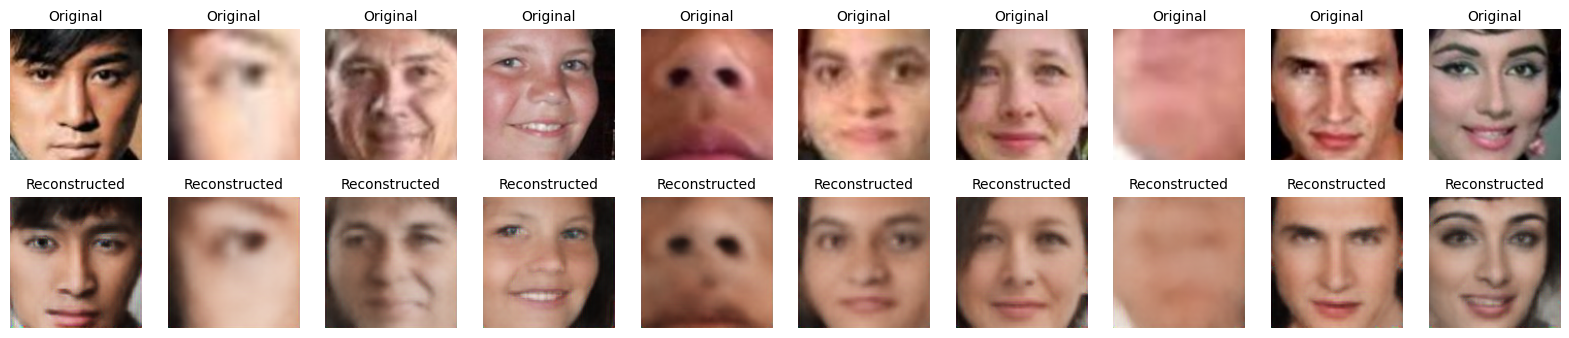

In [53]:
import matplotlib.pyplot as plt

n = 10  # Número de imágenes a mostrar

# Tomar las primeras n imágenes y edades
x_sample = tf.convert_to_tensor(x_test[:n], dtype=tf.float32)
age_sample = tf.convert_to_tensor(x_test_ages[:n], dtype=tf.float32)

# Obtener las representaciones latentes y los skips
z_mean, z_log_var, z = vae.encoder([x_sample, age_sample], training=False)

# Decodificar las imágenes
decoded_imgs, _ = vae.decoder([z, age_sample], training=False)

# Configuración de la figura
plt.figure(figsize=(20, 4))

for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_sample[i].numpy())
    plt.axis("off")
    plt.title("Original", fontsize=10)

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].numpy())
    plt.axis("off")
    plt.title("Reconstructed", fontsize=10)

plt.show()


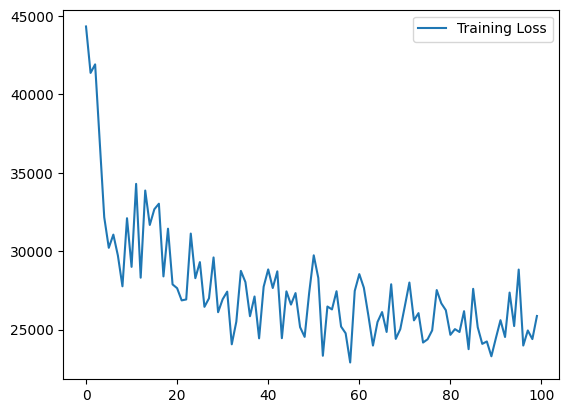

In [22]:
loss = history.history['loss']

epoch_range = range(epochs)

plt.plot(epoch_range, loss, label='Training Loss')
plt.legend()
plt.show()

In [46]:
def generate_age_variations(img_path, ages=[5, 15, 25, 40, 60, 80]):
    """
    Genera múltiples versiones de una imagen con diferentes edades.
    Requiere:
        - vae: modelo entrenado
        - preprocess_image: debe devolver recortes faciales normalizados [0,1]
    """

    # --- Preprocesamiento ---
    face_crops = preprocess_image(img_path)
    if len(face_crops) == 0:
        raise ValueError("No se detectó ninguna cara en la imagen.")

    face = face_crops[0]

    # Batch de tamaño 1
    face_batch = np.expand_dims(face, axis=0)
    face_tensor = tf.convert_to_tensor(face_batch, dtype=tf.float32)

    decoded_results = []

    # --- Procesar cada edad ---
    for age_value in ages:
        age_tensor = tf.convert_to_tensor([[age_value]], dtype=tf.float32)

        # Encode + obtener skips
        enc_out = vae.encoder([face_tensor, age_tensor], training=False)
        z_mean, z_log_var, z = enc_out[:3]

        # Decode con skips
        decoded_img, _ = vae.decoder([z, age_tensor], training=False)

        decoded_results.append(decoded_img[0].numpy())

    # --- Mostrar ---
    plt.figure(figsize=(3 * len(ages), 4))

    # Mostrar imagen original
    plt.subplot(1, len(ages) + 1, 1)
    plt.imshow(face)
    plt.title("Original")
    plt.axis("off")

    # Mostrar variaciones
    for i, age_value in enumerate(ages):
        plt.subplot(1, len(ages) + 1, i + 2)
        plt.imshow(decoded_results[i])
        plt.title(f"Edad: {age_value}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    return decoded_results

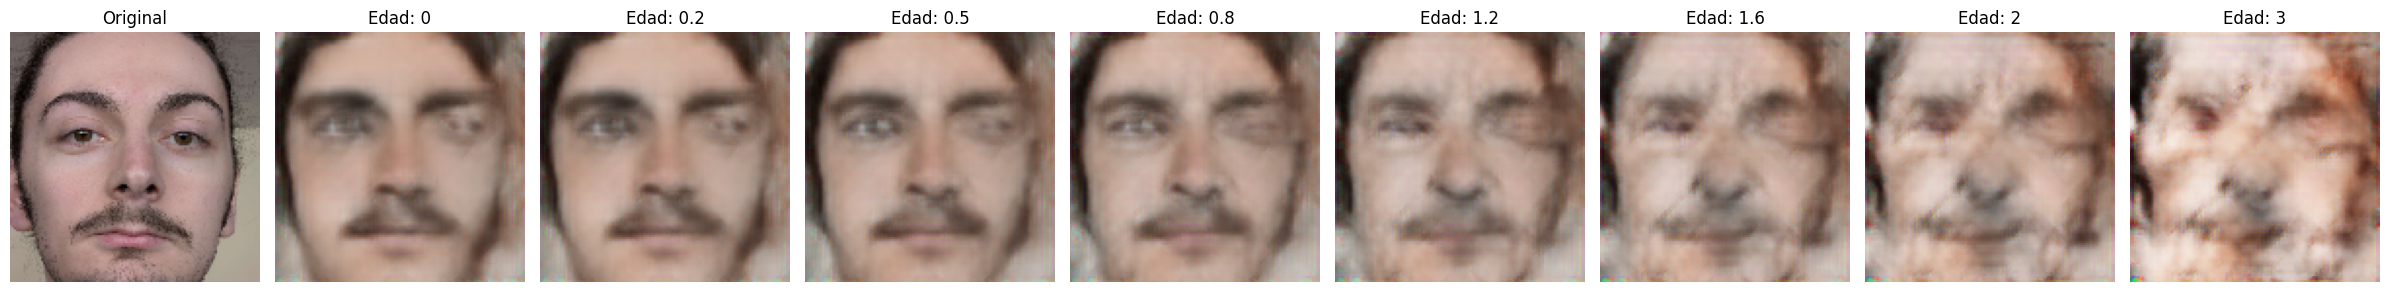

[array([[[0.7388905 , 0.4632217 , 0.57538927],
         [0.76524234, 0.58944625, 0.5977975 ],
         [0.68579656, 0.6232884 , 0.62699807],
         ...,
         [0.57772124, 0.5471204 , 0.47916666],
         [0.5921606 , 0.50789815, 0.47044995],
         [0.56914836, 0.5054781 , 0.46684018]],
 
        [[0.7029457 , 0.5337087 , 0.7052433 ],
         [0.7645132 , 0.6023378 , 0.6224454 ],
         [0.71480435, 0.6663246 , 0.5356462 ],
         ...,
         [0.5621224 , 0.5780037 , 0.52625215],
         [0.5945523 , 0.53547895, 0.5379154 ],
         [0.636463  , 0.49559644, 0.5240364 ]],
 
        [[0.7304668 , 0.60701734, 0.6425325 ],
         [0.7604659 , 0.6480478 , 0.66602015],
         [0.6709695 , 0.6445052 , 0.6015977 ],
         ...,
         [0.5953876 , 0.51307607, 0.5052344 ],
         [0.623644  , 0.5007872 , 0.5799591 ],
         [0.62657475, 0.5496558 , 0.59940815]],
 
        ...,
 
        [[0.53445894, 0.54444486, 0.533043  ],
         [0.5484918 , 0.4947898 , 0.68151

In [47]:
generate_age_variations(
    img_path="../Images/V.jpg",
    # ages=[0, -5, -2 ,-1, 1, 2, 5]
    ages=[0, 0.2, 0.5, 0.8, 1.2, 1.6, 2, 3]
)